In [4]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, GRU, Reshape
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [6]:
X_train = np.load('training_data\specs_train_processed.npy')
print(f"before: {X_train.shape}")
X_train = np.swapaxes(X_train,2,1)
print(f"after: {X_train.shape}")
X_train = np.expand_dims(X_train,3)
print(f"final: {X_train.shape}")
y_train = np.load('training_data\labels_train_processed.npy')

before: (7984, 100, 130)
after: (7984, 130, 100)
final: (7984, 130, 100, 1)


In [7]:
X_train.shape[1:]

(130, 100, 1)

In [59]:
from keras import Model
from keras.layers import Input, Dense, concatenate
N_CLASSES = 10
a_input = Input(shape = X_train.shape[1:])
#1
a = Conv2D(filters=16, kernel_size=(3,3), input_shape=X_train.shape[1:])(a_input)
a = MaxPool2D(pool_size=(2,2))(a)
a = BatchNormalization()(a)
#2
a = Conv2D(filters=32, kernel_size=(3,3))(a)
a = (MaxPool2D(pool_size=(2,2)))(a)
a = (BatchNormalization())(a)
#3
a=(Conv2D(filters=64, kernel_size=(3,3)))(a)
a=(MaxPool2D(pool_size=(2,2)))(a)
a=(BatchNormalization())(a)
#4
a=(Conv2D(filters=128, kernel_size=(3,3)))(a)
a=(MaxPool2D(pool_size=(1,5)))(a)
a=(BatchNormalization())(a)

a = (Reshape((12,128)))(a)
# Recurrent Layer
a= (GRU(256, activation="tanh"))(a)
a = Model(inputs=a_input, outputs=a)


In [75]:
features = pd.read_csv("features_final.csv")
features = features.drop('Unnamed: 0',axis=1)
features.shape

(7994, 58)

In [61]:
b_input= Input(shape = features.shape[1:])
b = (Dense(128))(b_input)
b = Model(inputs=b_input, outputs=b)

(58,)


In [72]:
mixed = concatenate([a.output,b.output])
z = Dense(64)(mixed)
z = Dropout(0.4)(z)
z = Dense(N_CLASSES,activation='softmax')(z)
# Output Layer

In [73]:
model = Model(inputs=[a.input, b.input], outputs=z)


In [57]:
# N_CLASSES = 10
# model = Sequential(name="gtzan_crnn")

# # Convolutional Block 1
# model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=X_train.shape[1:])) # X_train holds the processed training spectrograms
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# # Convolutional Block 2
# model.add(Conv2D(filters=32, kernel_size=(3,3)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# # Convolutional Block 3
# model.add(Conv2D(filters=64, kernel_size=(3,3)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# # Convolutional Block 4
# model.add(Conv2D(filters=128, kernel_size=(3,3)))
# model.add(MaxPool2D(pool_size=(1,5)))
# model.add(BatchNormalization())

# # Reshape Layer (effectively squeezes the frequency dimension away)
# model.add(Reshape((12,128)))
# # Recurrent Layer
# model.add(GRU(256, return_sequences=False, activation="tanh"))

# # Dense Layer
# model.add(Dense(64))
# model.add(Dropout(0.4))

# # Output Layer
# model.add(Dense(N_CLASSES, activation="softmax"))

In [74]:
x_valid = np.load('training_data\specs_val_processed.npy')
x_valid = np.swapaxes(x_valid,2,1)
x_valid = np.expand_dims(x_valid,3)
y_valid = np.load('training_data\labels_val_processed.npy')

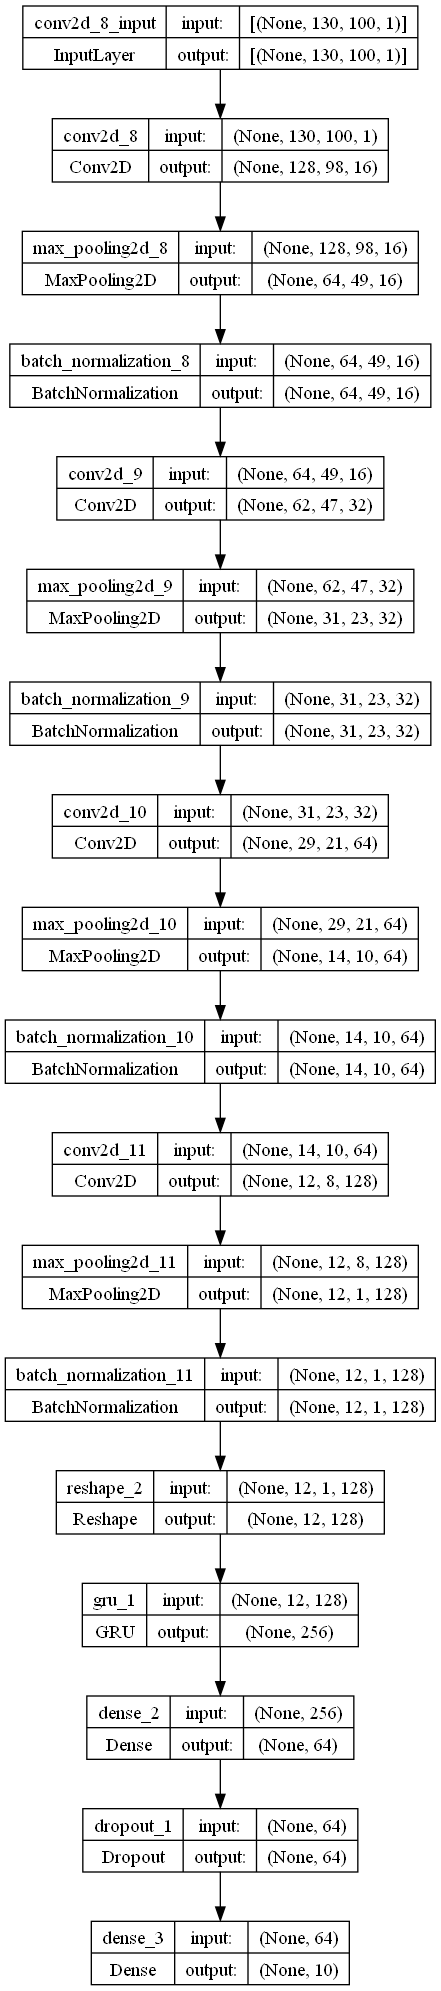

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
model.fit(x= [X_train,features], y=y_train, epochs = 25, validation_data = ([x_valid,features_valid], y_valid), batch_size=64)

Epoch 1/25
125/125 [==============================] - 41s 232ms/step - loss: 2.1410 - accuracy: 0.2112 - val_loss: 2.4339 - val_accuracy: 0.1010
Epoch 2/25
125/125 [==============================] - 29s 235ms/step - loss: 1.9778 - accuracy: 0.2752 - val_loss: 2.7355 - val_accuracy: 0.1030
Epoch 3/25
 81/125 [==================>...........] - ETA: 9s - loss: 1.8858 - accuracy: 0.3086

KeyboardInterrupt: 

In [11]:
x_test = np.load('training_data\specs_test_processed.npy')
x_test = np.swapaxes(x_test,2,1)
x_test = np.expand_dims(x_test,3)
y_test = np.load('training_data\labels_test_processed.npy')

In [1]:
model.evaluate(x=x_test, y=y_test)

NameError: name 'model' is not defined

## Confusion Matrix

In [35]:
genres = {
 0:'blues',
 1:'classical',
 2:'country',
 3:'disco',
 4:'hiphop',
 5:'jazz',
 6:'metal',
 7:'pop',
 8:'reggae',
 9:'rock'
}

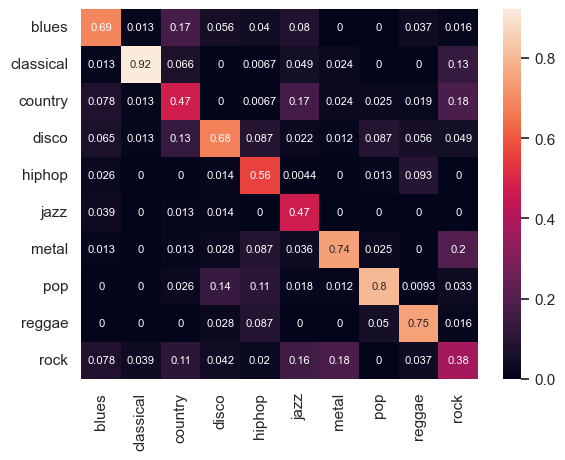

In [39]:

y_prediction = model.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

df_cm = pd.DataFrame(result, (genres.values()), (genres.values()))
#plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size

plt.show()

In [23]:
data.shape

NameError: name 'data' is not defined